# Evaluation Method

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Load Model

In [ ]:
model1_df = pd.read_csv('model1_df.csv') #Fine-tuning with FinBERT as label
model2_df = pd.read_csv('model2_df.csv') #Fine-tuning with return_next as label
model3_df = pd.read_csv('model3_df.csv') #Fine-tuning with LLM as label
fin_model_df = pd.read_csv('fin_model_df.csv') #FinBERT only

### Choose Stock

In [14]:
stock = "MSFT"
stock_df = yf.download(stock, start="2024-01-01", end="2025-05-01", multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_df = stock_df['Close'].to_frame().reset_index()

display(stock_df.head())
display(stock_df.shape)

,Date,Close
0,2024-01-02,367.380615
1,2024-01-03,367.113159
2,2024-01-04,364.478149
3,2024-01-05,364.289948
4,2024-01-08,371.164673


(333, 2)

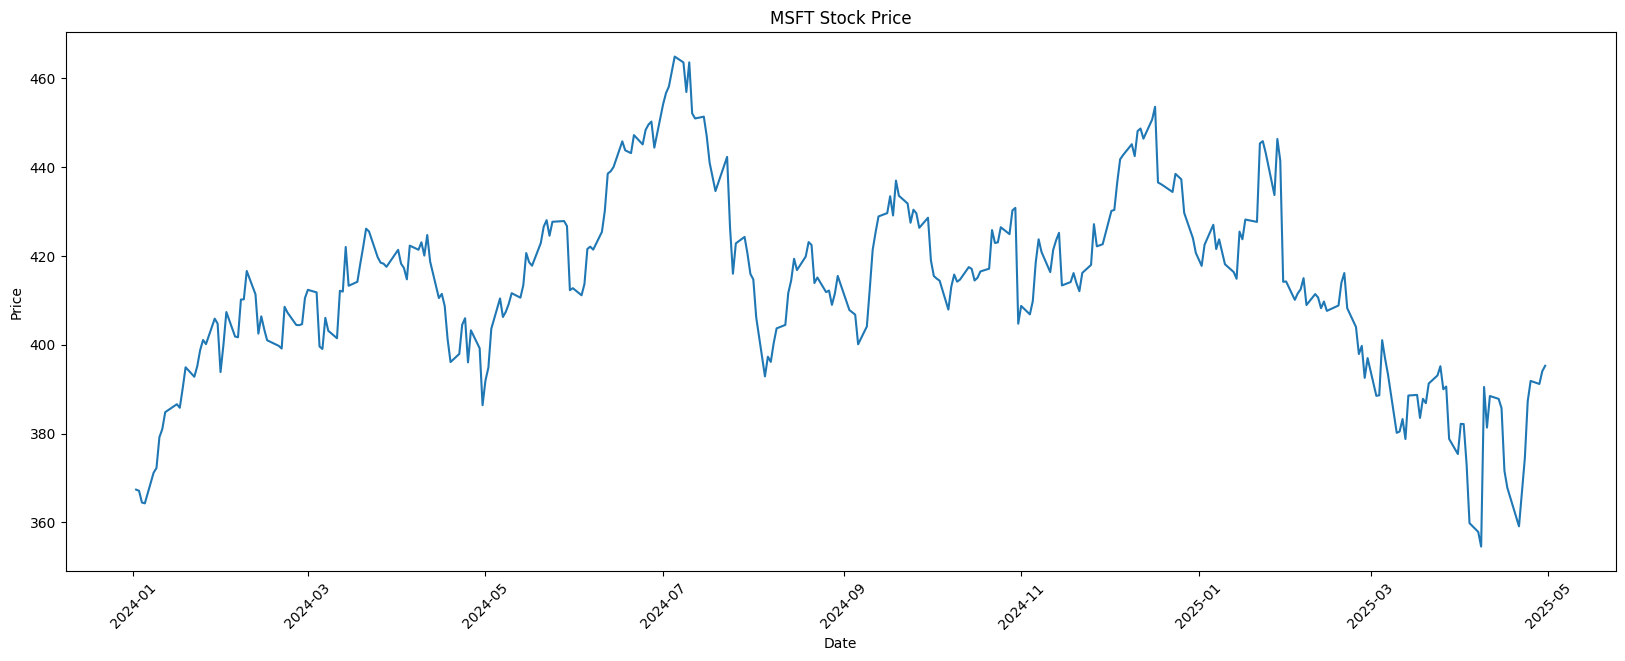

In [25]:
plt.figure(figsize=(20, 7))
plt.plot(stock_df['Date'], stock_df['Close'])
plt.title(f"{stock} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

In [29]:
stock_df['pct_change'] = stock_df['Close'].pct_change()
stock_df['pct_change'] = stock_df['pct_change'].shift(-1)
stock_df['pct_change'] = stock_df['pct_change'].fillna(0)
display(stock_df.head())
display(stock_df.tail())

,Date,Close,pct_change
0,2024-01-02,367.380615,-0.000728
1,2024-01-03,367.113159,-0.007178
2,2024-01-04,364.478149,-0.000516
3,2024-01-05,364.289948,0.018872
4,2024-01-08,371.164673,0.002936


,Date,Close,pct_change
328,2025-04-24,387.299988,0.011748
329,2025-04-25,391.850006,-0.001761
330,2025-04-28,391.160004,0.007363
331,2025-04-29,394.040009,0.003096
332,2025-04-30,395.260010,0.000000


In [ ]:
#Merge the stock data with the model dataframes
model1_df = model1_df.merge(stock_df, on='Date', how='left')
model2_df = model2_df.merge(stock_df, on='Date', how='left')
model3_df = model3_df.merge(stock_df, on='Date', how='left')
fin_model_df = fin_model_df.merge(stock_df, on='Date', how='left')

In [44]:
stock_df['label_model1'] = np.random.choice([-1, 0, 1], size=len(stock_df))
stock_df['label_model2'] = np.random.choice([-1, 0, 1], size=len(stock_df))
stock_df['label_model3'] = np.random.choice([-1, 0, 1], size=len(stock_df))
stock_df['label_fin_model'] = np.random.choice([-1, 0, 1], size=len(stock_df))

In [45]:
display(stock_df.head())

,Date,Close,pct_change,label,label_model1,label_model2,label_model3,label_fin_model
0,2024-01-02,367.380615,-0.000728,NaN,1,-1,1,1
1,2024-01-03,367.113159,-0.007178,0.0,0,-1,1,1
2,2024-01-04,364.478149,-0.000516,1.0,0,0,-1,0
3,2024-01-05,364.289948,0.018872,-1.0,1,-1,-1,1
4,2024-01-08,371.164673,0.002936,-1.0,-1,0,1,-1


## 1. Correlation

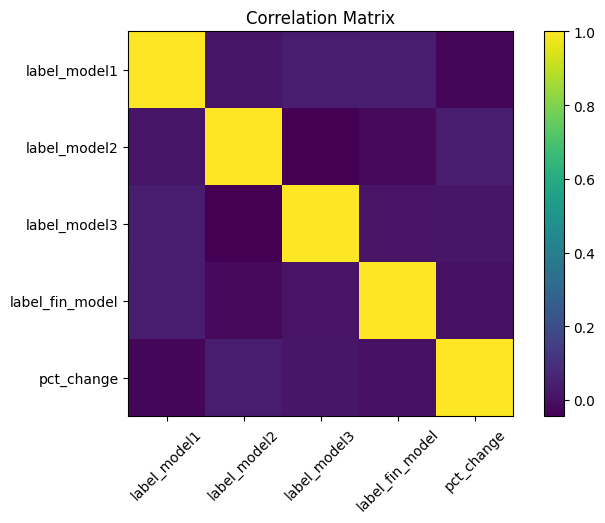

In [50]:
correlation_df=stock_df[['label_model1', 'label_model2', 'label_model3', 'label_fin_model', 'pct_change']].copy()
correlation_df = correlation_df.corr()

plt.figure(figsize=(8, 5))
plt.title("Correlation Matrix")
plt.imshow(correlation_df, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_df.columns)), correlation_df.columns, rotation=45)
plt.yticks(range(len(correlation_df.columns)), correlation_df.columns)
plt.grid(False)
plt.show()

## 2. Techincal Analysis

### Simple Moving Average

In [67]:
stock_df['SMA_20'] = stock_df['Close'].rolling(window=20).mean()
stock_df['SMA_50'] = stock_df['Close'].rolling(window=50).mean()

stock_df['sma_signal'] = 0
stock_df.loc[stock_df['SMA_20'] > stock_df['SMA_50'], 'sma_signal'] = 1
stock_df.loc[stock_df['SMA_20'] < stock_df['SMA_50'], 'sma_signal'] = -1

### RSI

In [64]:
stock_df['RSI'] = ta.momentum.RSIIndicator(stock_df['Close'], window=14).rsi()

stock_df['rsi_signal'] = 0
stock_df.loc[stock_df['RSI'] < 30, 'rsi_signal'] = 1
stock_df.loc[stock_df['RSI'] > 70, 'rsi_signal'] = -1

### MACD

In [65]:
macd = ta.trend.MACD(stock_df['Close'])
stock_df['MACD'] = macd.macd()
stock_df['MACD_signal'] = macd.macd_signal()

stock_df['macd_signal_line'] = 0
stock_df.loc[stock_df['MACD'] > stock_df['MACD_signal'], 'macd_signal_line'] = 1
stock_df.loc[stock_df['MACD'] < stock_df['MACD_signal'], 'macd_signal_line'] = -1

### Bollinger Bands

In [66]:
bb = ta.volatility.BollingerBands(stock_df['Close'])
stock_df['bb_upper'] = bb.bollinger_hband()
stock_df['bb_lower'] = bb.bollinger_lband()

stock_df['bb_signal'] = 0
stock_df.loc[stock_df['Close'] < stock_df['bb_lower'], 'bb_signal'] = 1
stock_df.loc[stock_df['Close'] > stock_df['bb_upper'], 'bb_signal'] = -1

In [70]:
stock_df['sma_return']=stock_df['sma_signal'].shift(1)*stock_df['pct_change']
stock_df['RSI_return']=stock_df['rsi_signal'].shift(1)*stock_df['pct_change']
stock_df['MACD_return']=stock_df['macd_signal_line'].shift(1)*stock_df['pct_change']
stock_df['BB_return']=stock_df['bb_signal'].shift(1)*stock_df['pct_change']

In [73]:
stock_df['Next_Close'] = stock_df['Close'].shift(-1)
stock_df['Return'] = (stock_df['Next_Close'] - stock_df['Close']) / stock_df['Close']

stock_df['Strategy_Return_Model1'] = stock_df['label_model1'].shift(0) * stock_df['Return']
stock_df['Strategy_Return_Model2'] = stock_df['label_model2'].shift(0) * stock_df['Return']
stock_df['Strategy_Return_Model3'] = stock_df['label_model3'].shift(0) * stock_df['Return']
stock_df['Strategy_Return_Fin_Model'] = stock_df['label_fin_model'].shift(0) * stock_df['Return']


stock_df['Model1_Cumulative'] = (1 + stock_df['Strategy_Return_Model1'].fillna(0)).cumprod()
stock_df['Model2_Cumulative'] = (1 + stock_df['Strategy_Return_Model2'].fillna(0)).cumprod()
stock_df['Model3_Cumulative'] = (1 + stock_df['Strategy_Return_Model3'].fillna(0)).cumprod()
stock_df['Fin_Model_Cumulative'] = (1 + stock_df['Strategy_Return_Fin_Model'].fillna(0)).cumprod()
stock_df['BuyHold_Cumulative'] = (1 + stock_df['Return'].fillna(0)).cumprod()
stock_df['SMA_Cumulative'] = (1 + stock_df['sma_return'].fillna(0)).cumprod()
stock_df['RSI_Cumulative'] = (1 + stock_df['RSI_return'].fillna(0)).cumprod()
stock_df['MACD_Cumulative'] = (1 + stock_df['MACD_return'].fillna(0)).cumprod()
stock_df['BB_Cumulative'] = (1 + stock_df['BB_return'].fillna(0)).cumprod()

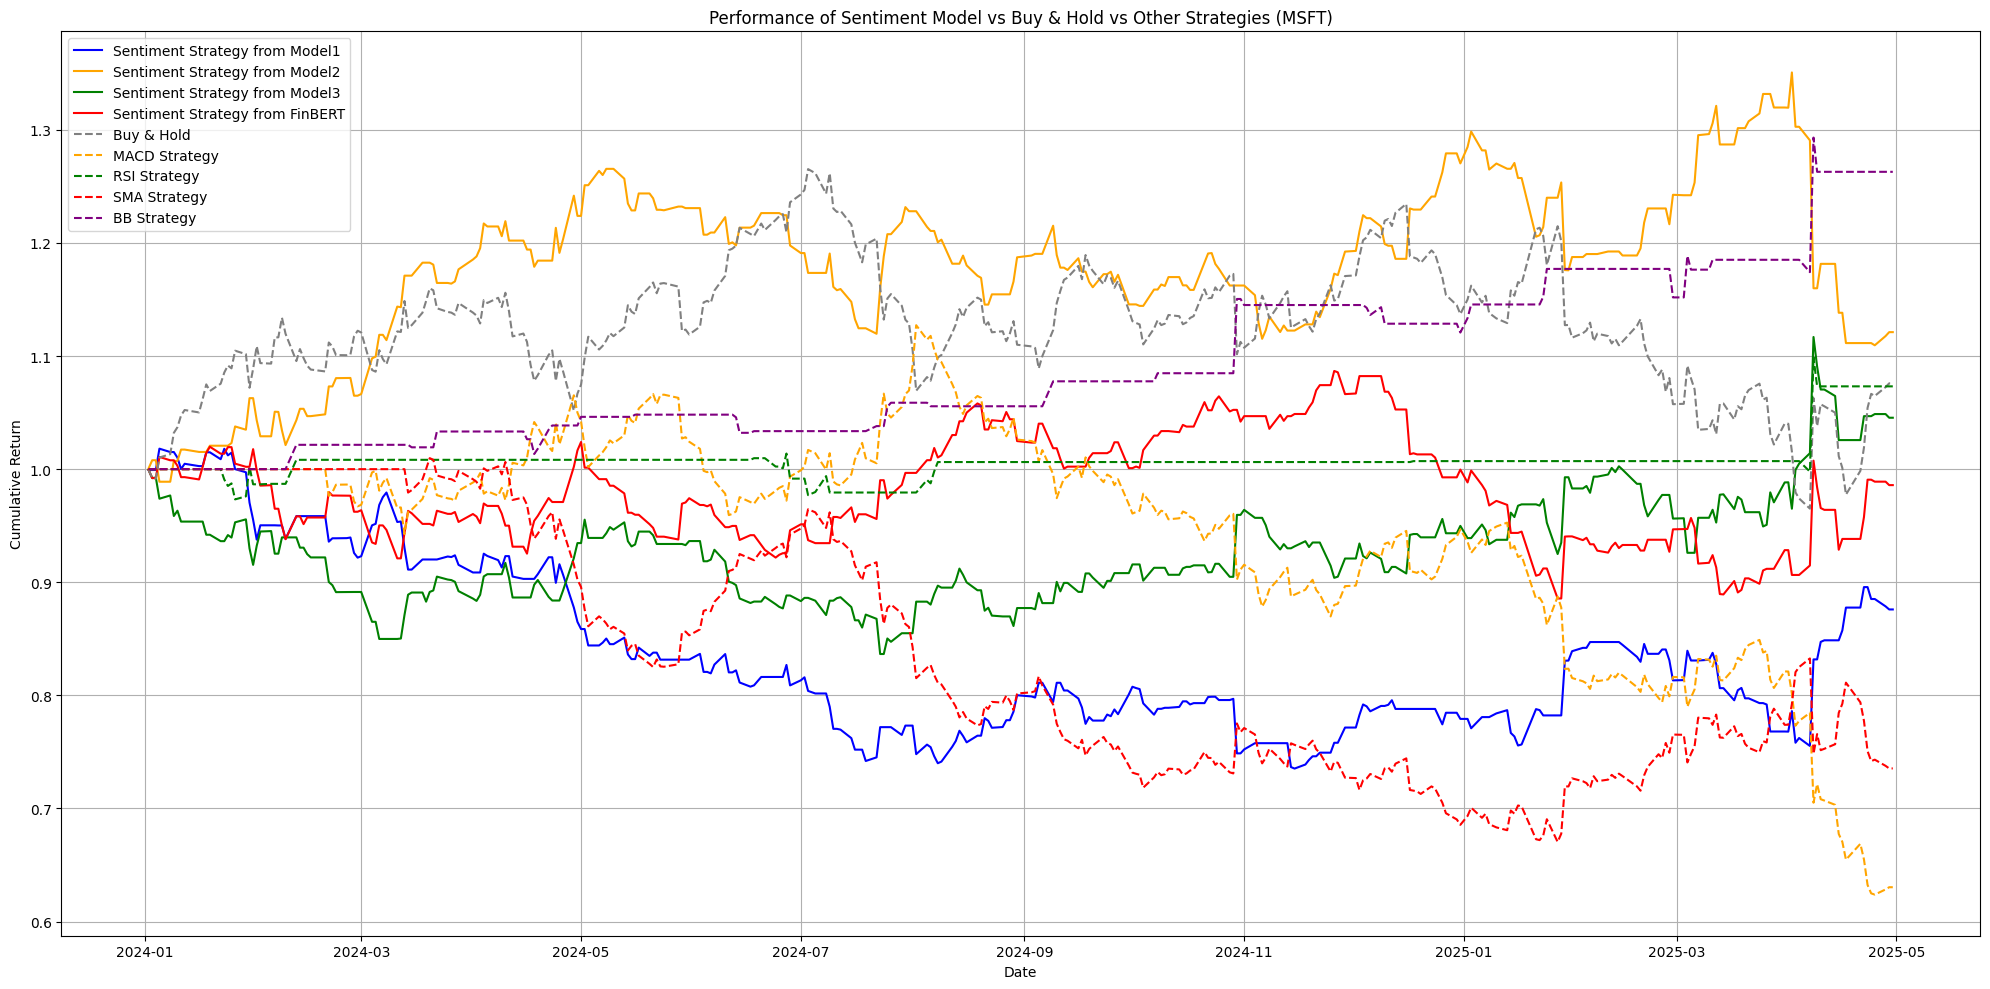

In [78]:
plt.figure(figsize=(20, 10))
plt.plot(stock_df['Date'], stock_df['Model1_Cumulative'], label='Sentiment Strategy from Model1', color='blue')
plt.plot(stock_df['Date'], stock_df['Model2_Cumulative'], label='Sentiment Strategy from Model2', color='orange')
plt.plot(stock_df['Date'], stock_df['Model3_Cumulative'], label='Sentiment Strategy from Model3', color='green')
plt.plot(stock_df['Date'], stock_df['Fin_Model_Cumulative'], label='Sentiment Strategy from FinBERT', color='red')
plt.plot(stock_df['Date'], stock_df['BuyHold_Cumulative'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(stock_df['Date'], stock_df['MACD_Cumulative'], label='MACD Strategy', linestyle='--', color='orange')
plt.plot(stock_df['Date'], stock_df['RSI_Cumulative'], label='RSI Strategy', linestyle='--', color='green')
plt.plot(stock_df['Date'], stock_df['SMA_Cumulative'], label='SMA Strategy', linestyle='--', color='red')
plt.plot(stock_df['Date'], stock_df['BB_Cumulative'], label='BB Strategy', linestyle='--', color='purple')
plt.title(f"Performance of Sentiment Model vs Buy & Hold vs Other Strategies ({stock})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()